In [1]:
#Objectives: 
#Nous allons parcourir la base de données de Mercedes Benz 
#Cette base de données contient les différentes options des voitures constuites,
#C'est variables sont d'écrites sous forme de variables anonymes
#La variable Y représente le temps qu'une voiture passe dans la borne de test 


In [90]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import pylab as P
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.linear_model import ElasticNetCV, LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import check_array

from sklearn.metrics import r2_score

In [91]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed

In [185]:
import xgboost as xgb

In [92]:
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Importation des données:

In [147]:
#récuperation des données 
#données pour le train
data_train = pd.read_csv("data/train.csv")
#données pour le test 
data_test = pd.read_csv("data/test.csv")


# Exploration des données:

In [94]:
#dimension du train et test: 
data_train.shape
print("Notre jeu de donnée train est de dimension:",data_train.shape)
print("Notre jeu de donnée test est de dimension:",data_test.shape)


Notre jeu de donnée train est de dimension: (4209, 378)
Notre jeu de donnée test est de dimension: (4209, 377)


In [95]:
#une aperçu sur le train 
data_train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [96]:
#Recherche de valeurs manquantes 
print(data_train.isnull().sum().sum())

0


On peut voir qu'il y a pas des valeurs manquantes


In [97]:
data_train.isnull().values.any()

False

In [98]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


On a 8 variables qualitatives et 369 variables booléen 

La variable Y est la variable temps passée par une voiture dans le branche de test pour chaque variable.
c'est la variable qu'on va prédir après 
   

In [100]:
#description de la variable réponse:
print(data_train["y"].describe(include='all'))

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64


In [101]:
dtype_data = data_train.dtypes.reset_index()
dtype_data.loc[:10,:]

,index,0
0,ID,int64
1,y,float64
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


On remarque que les variables "X0","X1","X2","X3","X4","X5","X6","X8" sont les variables qualitatives 
tandis que notre variables réponse "y" est un réel

In [102]:
#datacor=data_train.iloc[0:,10:]

In [103]:
#corr = datacor.corr() # matrix de correlation
#f, ax = plt.subplots(figsize=(11, 9))
#sns.heatmap(corr,annot=True, vmax=.3)
#plt.show()


In [104]:
#import seaborn as sns
#corr = data_uant.corr()
#sns.heatmap(corr, 
           # xticklabels=corr.columns.values,
           # yticklabels=corr.columns.values)

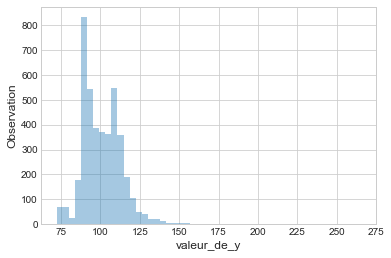

In [105]:
sns.distplot(data_train.y.values, bins=50, kde=False)
plt.xlabel('valeur_de_y', fontsize=12)
plt.ylabel('Observation', fontsize=12)

plt.show()

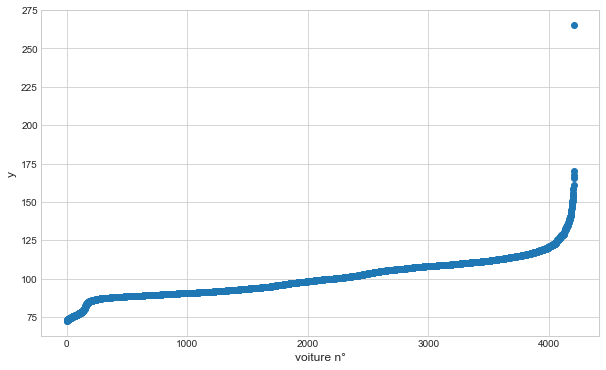

In [106]:
#on va voir la réaction de la variable Y
plt.figure(figsize=(10,6))
plt.scatter(range(data_train.shape[0]), np.sort(data_train.y.values))
plt.xlabel('voiture n°', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

In [114]:
#valeurs prise par chaque la var X0
val_X0 = np.sort(data_train["X0"].unique()).tolist()
print(val_X0)

['a', 'aa', 'ab', 'ac', 'ad', 'af', 'ai', 'aj', 'ak', 'al', 'am', 'ao', 'ap', 'aq', 'as', 'at', 'au', 'aw', 'ax', 'ay', 'az', 'b', 'ba', 'bc', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [116]:
#valeurs prise par chaque la var X1
val_X1 = np.sort(data_train["X1"].unique()).tolist()
print(val_X1)

['a', 'aa', 'ab', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z']


In [ ]:
#valeurs prise par chaque la var
var="X2"
val_ = np.sort(data_train[var].unique()).tolist()
print(val_X2)

In [123]:
#valeurs prise par chaque la var X1
val_X5 = np.sort(data_train["X2"].unique()).tolist()
print(val_X5)

['a', 'aa', 'ac', 'ae', 'af', 'ag', 'ah', 'ai', 'ak', 'al', 'am', 'an', 'ao', 'ap', 'aq', 'ar', 'as', 'at', 'au', 'av', 'aw', 'ay', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'x', 'y', 'z']


# Exploration de la variable X0

In [108]:
#exploration de la variable X0
data_train['X0'].value_counts()


z     360
ak    349
y     324
ay    313
t     306
x     300
o     269
f     227
n     195
w     182
j     181
az    175
aj    151
s     106
ap    103
h      75
d      73
al     67
v      36
af     35
ai     34
m      34
e      32
ba     27
at     25
a      21
ax     19
i      18
aq     18
am     18
u      17
aw     16
l      16
ad     14
au     11
k      11
b      11
as     10
r      10
bc      6
ao      4
c       3
q       2
aa      2
g       1
ab      1
ac      1
Name: X0, dtype: int64

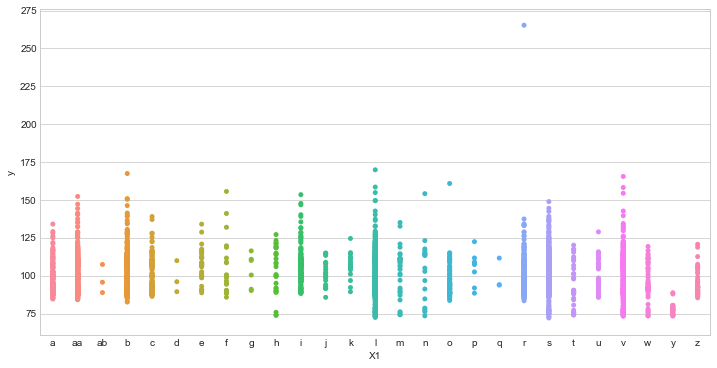

In [125]:
var="X1"
col_order = np.sort(data_train[var].unique()).tolist()
plt.figure(figsize=(12,6))
sns.stripplot(x=var, y='y', data=data_train, order=col_order)


C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


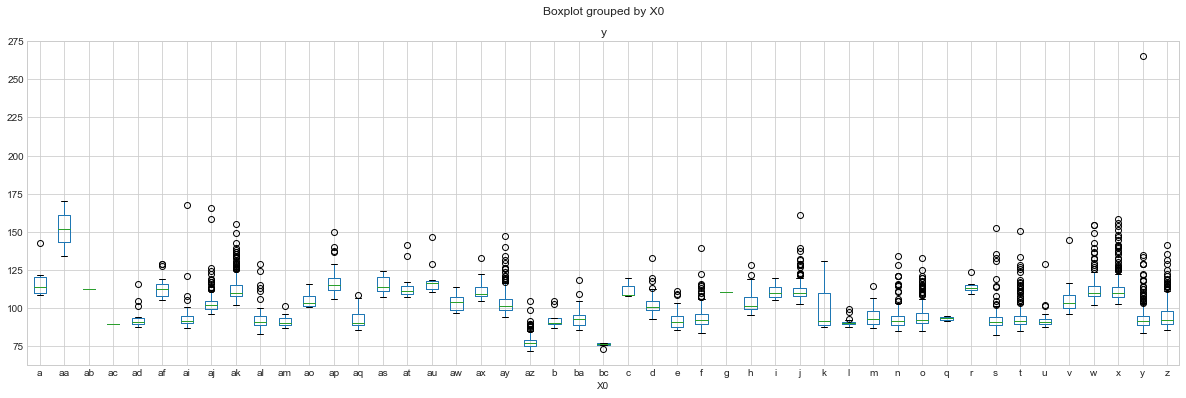

In [110]:

data_train.boxplot(column="y",by="X0",figsize=(20,6)) 


In [21]:
# table de contingence
#Un tableau de contingence est une manière efficace de résumer la relation entre deux variables qualitatives
table=pd.crosstab(data_train["X1"],data_train["X0"])
print(table)

X0   a  aa  ab  ac  ad  af  ai  aj   ak  al ...   q  r   s    t  u   v    w  \
X1                                          ...                               
a    0   0   0   0   4   0   0   4    2   3 ...   0  0   0    0  1   0    0   
aa   0   0   0   0   0   0   4   0    0   3 ...   0  0  54  111  0   0    0   
ab   0   0   0   0   0   0   0   0    0   0 ...   0  0   0    0  0   0    0   
b    0   0   0   0   0   0  22   0    0   4 ...   0  0  30  151  0   0    0   
c    0   0   0   0   0   2   0   6   12   0 ...   0  2   0    0  2   3    8   
d    0   0   0   0   0   0   0   0    0   0 ...   0  0   0    0  0   0    0   
e    0   0   0   0   0   4   0   4    7   0 ...   0  1   0    0  0   2    8   
f    0   0   0   0   0   0   3   0    0   0 ...   0  0   1    3  0   0    0   
g    0   0   0   0   0   0   0   0    0   0 ...   0  0   2    0  0   0    0   
h    0   0   0   0   2   0   0   2   10   0 ...   0  0   0    0  0   0    1   
i    0   0   0   0   0   0   1   0    0   0 ...   0 

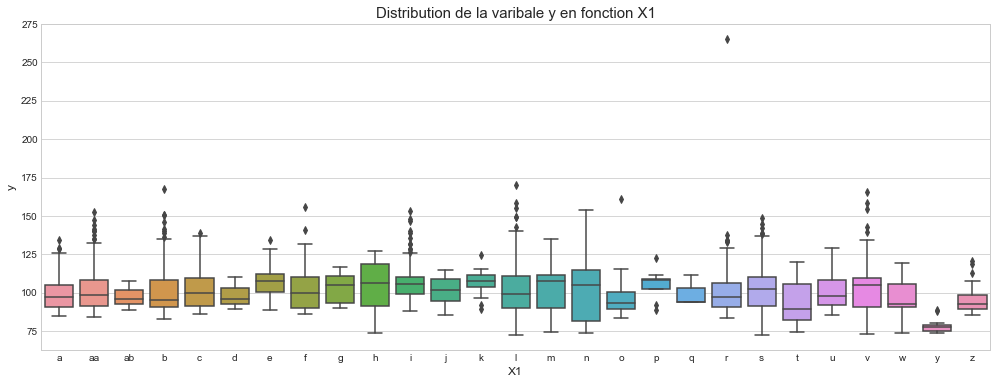

In [130]:


var_name = "X1"
col_order = np.sort(data_train[var_name].unique()).tolist()
plt.figure(figsize=(17,6))
sns.boxplot(x=var_name, y='y', data=data_train, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution de la varibale y en fonction "+var_name, fontsize=15)
plt.show()



# Exploration de la variable X1

In [45]:
# exploration de la variable X1
data_train['X1'].value_counts()


1     833
20    598
3     592
13    590
23    408
19    251
10    203
0     143
4     121
16     82
24     52
26     46
22     37
6      33
14     32
21     31
9      29
25     23
7      23
11     22
15     19
12     17
17      9
8       6
5       3
2       3
18      3
Name: X1, dtype: int64

C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Distribution de y par rapport à X1')

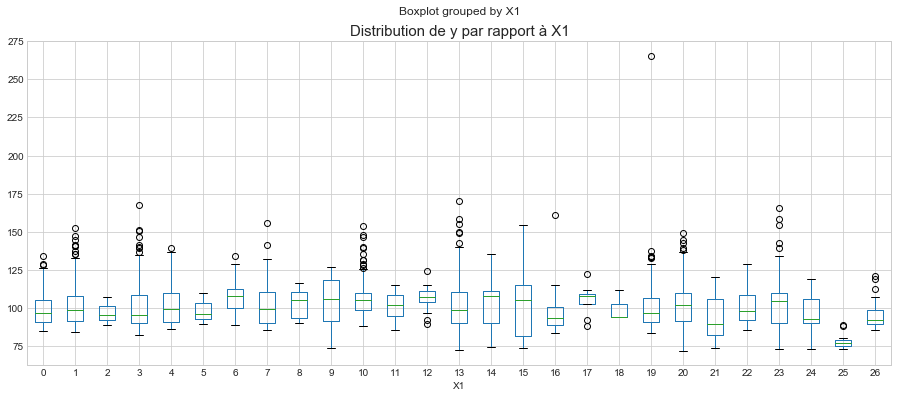

In [46]:
var="X1"
data_train.boxplot(column="y",by=var,figsize=(15,6)) 
plt.title("Distribution de y par rapport à "+var, fontsize=15)


In [47]:
table=pd.crosstab(data_train["X1"],data_train["X2"])
print(table)

X2  0   1   3    5   6   7   8    9   11  12 ...  38  39  40  41  42  43  44  \
X1                                           ...                               
0    0   0   0   16   0   1   0    2  83   0 ...   0   0   3   0   4   0   0   
1    0   0   0   29   0   1   4  195   8   0 ...   5   0   0   1   2   0   0   
2    0   0   0    1   0   0   0    2   0   0 ...   0   0   0   0   0   0   0   
3   27   1   0   69   0   0   0  126  21   0 ...   7   0   0   0  10   0   0   
4    0   0   5   32   0   0   0    0   6   0 ...   2   0   0   0   6  10   0   
5    0   0   0    0   0   0   0    0   2   0 ...   0   0   0   0   0   0   0   
6    0   0   0    0   0   0   0    0   0   0 ...   0   0   0   0   0   0   0   
7    0   0   0    5   0   1   0    1   2   0 ...   0   0   0   0   0   0   0   
8    1   0   0    1   0   0   0    0   1   0 ...   0   0   0   0   0   0   0   
9    0   0   0    5   0   0   0    0   3   0 ...   2   0   0   0   0   1   0   
10   0   0   0   19   0   0   0    2   0

# Exploration de la variable X2

In [48]:
#exploration de la variable X2
data_train['X2'].value_counts()


19    1659
5      496
9      415
37     367
11     265
42     153
38     137
43      94
30      87
29      81
17      63
25      54
0       47
44      29
35      25
33      25
26      21
15      20
7       19
49      19
28      18
3       13
31      12
48      11
16      11
47      10
23       8
20       6
32       6
41       5
14       5
12       5
8        4
40       4
22       4
21       3
34       1
36       1
1        1
27       1
39       1
18       1
13       1
6        1
Name: X2, dtype: int64

C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Distribution de y par rapport à X2')

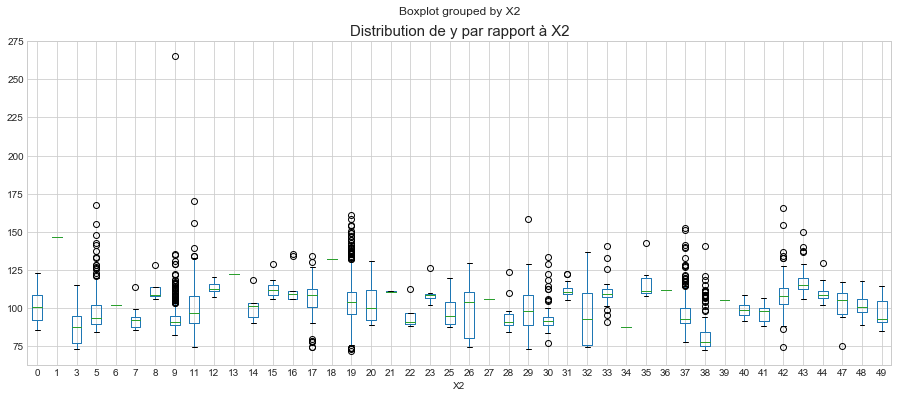

In [49]:
var="X2"
data_train.boxplot(column="y",by=var,figsize=(15,6)) 
plt.title("Distribution de y par rapport à "+var, fontsize=15)


# Exploration de la variable X3

In [173]:
#exploration de la variable X14
data_train['X14'].value_counts()


0    2407
1    1802
Name: X14, dtype: int64

C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Distribution de y par rapport à X3')

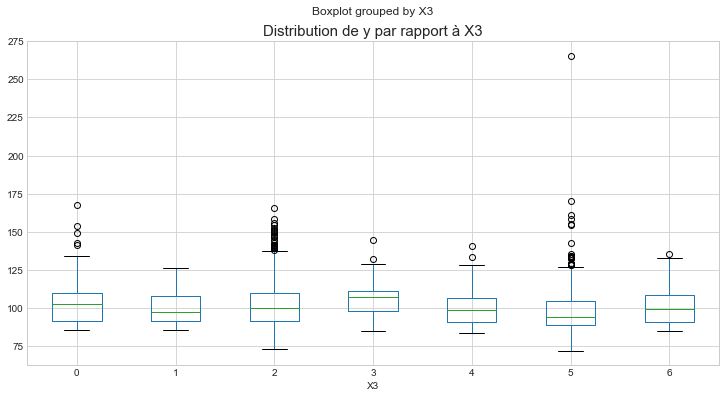

In [51]:
var="X3"
data_train.boxplot(column="y",by=var,figsize=(12,6)) 
plt.title("Distribution de y par rapport à "+var, fontsize=15)

# Exploration de la variable X4

In [52]:
#exploration de la variable X4
data_train['X4'].value_counts()


3    4205
0       2
2       1
1       1
Name: X4, dtype: int64

C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Distribution de y par rapport à X4')

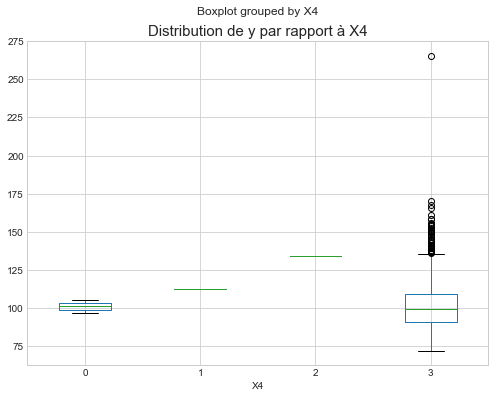

In [53]:
var="X4"
data_train.boxplot(column="y",by=var,figsize=(8,6)) 
plt.title("Distribution de y par rapport à "+var, fontsize=15)

# Exploration de la variable X5

In [54]:
#exploration de la variable X5
data_train['X5'].value_counts()


28    231
29    231
23    220
24    215
25    214
11    214
20    212
19    208
22    208
15    207
5     205
7     204
3     200
2     197
18    195
6     188
4     185
17    177
10    131
16    125
1     112
8      97
21     20
12      7
30      2
13      1
27      1
14      1
31      1
Name: X5, dtype: int64

C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Distribution de y par rapport à X5')

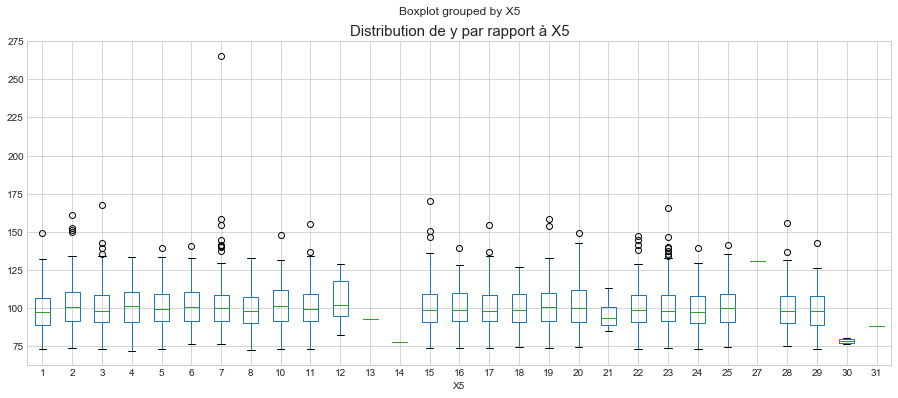

In [55]:
var="X5"
data_train.boxplot(column="y",by=var,figsize=(15,6)) 
plt.title("Distribution de y par rapport à "+var, fontsize=15)

# Exploration de la variable X6

In [56]:
#exploration de la variable X6
data_train['X6'].value_counts()


6     1042
9     1039
3      625
8      488
11     478
0      206
7      190
10      43
2       38
1       28
5       20
4       12
Name: X6, dtype: int64

C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Distribution de y par rapport à X6')

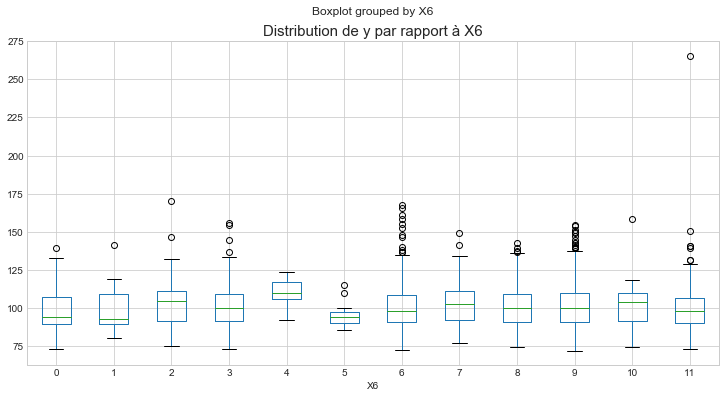

In [57]:
var="X6"
data_train.boxplot(column="y",by=var,figsize=(12,6)) 
plt.title("Distribution de y par rapport à "+var, fontsize=15)

# Exploration de la variable X8

In [58]:
#exploration de la variable X8
data_train['X8'].value_counts()


9     277
18    255
5     243
13    242
8     237
4     225
17    219
0     210
22    196
21    194
1     190
10    176
14    163
12    155
6     130
19    119
20    119
7     117
16    117
24    116
23    105
3     103
11    101
2     100
15    100
Name: X8, dtype: int64

C:\anacanda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Distribution de y par rapport à X8')

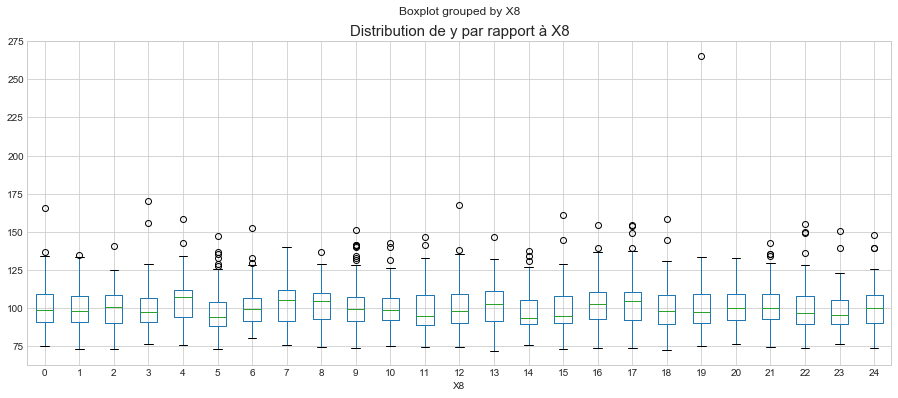

In [59]:
var="X8"
data_train.boxplot(column="y",by=var,figsize=(15,6)) 
plt.title("Distribution de y par rapport à "+var, fontsize=15)

Text(0.5,0,'Nombre de fois choisi')

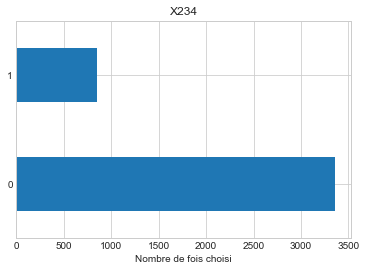

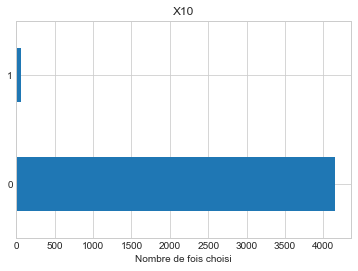

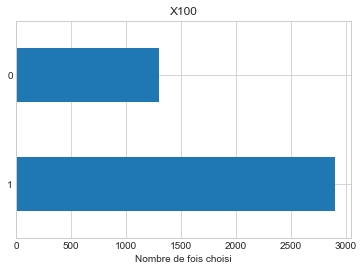

In [170]:

plt.figure(1)
var="X234"
data_train[var].value_counts().plot(kind='barh')
plt.title(var)
plt.xlabel('Nombre de fois choisi' )
var="X10"
plt.figure(2)
data_train[var].value_counts().plot(kind='barh')
plt.title(var)
plt.xlabel('Nombre de fois choisi' )

var="X100"
plt.figure(3)
data_train[var].value_counts().plot(kind='barh')
plt.title(var)
plt.xlabel('Nombre de fois choisi' )


Feature ranking:
1. Variable X1 (0.295902)
2. Variable X2 (0.208351)
3. Variable X0 (0.177632)
4. Variable X3 (0.047121)
5. Variable X6 (0.046303)
6. Variable X8 (0.046013)
7. Variable X7 (0.045575)
8. Variable X4 (0.044614)
9. Variable X9 (0.044577)
10. Variable X5 (0.043912)


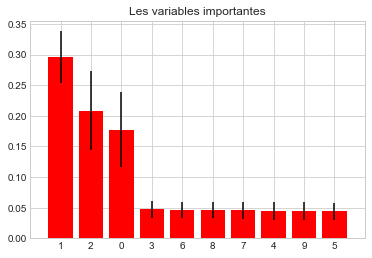

In [168]:
#variables importantes

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
y = data_train['y'].values
X = data_train.drop(["ID", "y"], axis=1)
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. Variable X%d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Les variables importantes")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [150]:
data_bool= data_train.drop(["ID","X0","X1","X2","X3","X4","X5","X6","X8"], axis=1)


In [159]:
data_bool.apply(pd.value_counts).plot(kind='bar', subplots=True)

KeyError: '[<function value_counts at 0x00000000082AE158>] not in index'

In [157]:
data_bool.hist(data_bool, column="X10", by="y", xlabelsize=12,ylabelsize=12,figsize=(12,6))

TypeError: hist_frame() got multiple values for argument 'column'

In [61]:
data_train["y"].mean()

100.66931812782121

In [62]:
#Données pour le test 
data_test = pd.read_csv("data/test.csv")

In [63]:
#dimension du frame 
data_test.shape

(4209, 377)

In [64]:
#data_test.head()

In [65]:
data_train[data_train["y"]>data_train["y"].mean()][["X0","X1","X2","X3"]]

,X0,X1,X2,X3
0,37,23,20,0
6,11,19,29,5
8,49,20,19,4
9,36,3,17,2
10,34,19,42,5
16,11,19,29,5
17,23,1,19,2
22,50,19,0,1
23,50,3,37,2
26,9,13,19,5


In [66]:
#Extrere les colonnes des deux variables X10, X380
#data_train.ix[:,["X10","X380"]]

In [67]:
test=data_train.as_matrix()
#print(test[:,10:385])

In [142]:
#transfomer les objets en code numérique 

for c in data_train:
    if data_train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(data_train[c].values)+list(data_test[c].values))
        data_train[c] = lbl.transform(list(data_train[c].values))
        data_test[c]= lbl.transform(list(data_test[c].values))
     


In [69]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(377)
memory usage: 12.1 MB


In [70]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 377 entries, ID to X385
dtypes: int64(369), object(8)
memory usage: 12.1+ MB


In [143]:
from sklearn.cross_validation import train_test_split

Y_train= data_train["y"].values
X_train= data_train.drop(["y","ID"], axis=1)
X_test = data_test.drop(["ID"], axis=1)



In [72]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 377 entries, ID to X385
dtypes: int64(369), object(8)
memory usage: 12.1+ MB


In [73]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 376 entries, X0 to X385
dtypes: int64(376)
memory usage: 12.1 MB


data_train["eval_set"]

In [144]:
#XGB
model_1 = XGBRegressor(learning_rate=0.01, n_estimators=400, subsample=0.8, 
                      colsample_bytree=0.8, max_depth =10)
model_1.fit(X_train, Y_train)

Y_predict = model_1.predict(X_test)

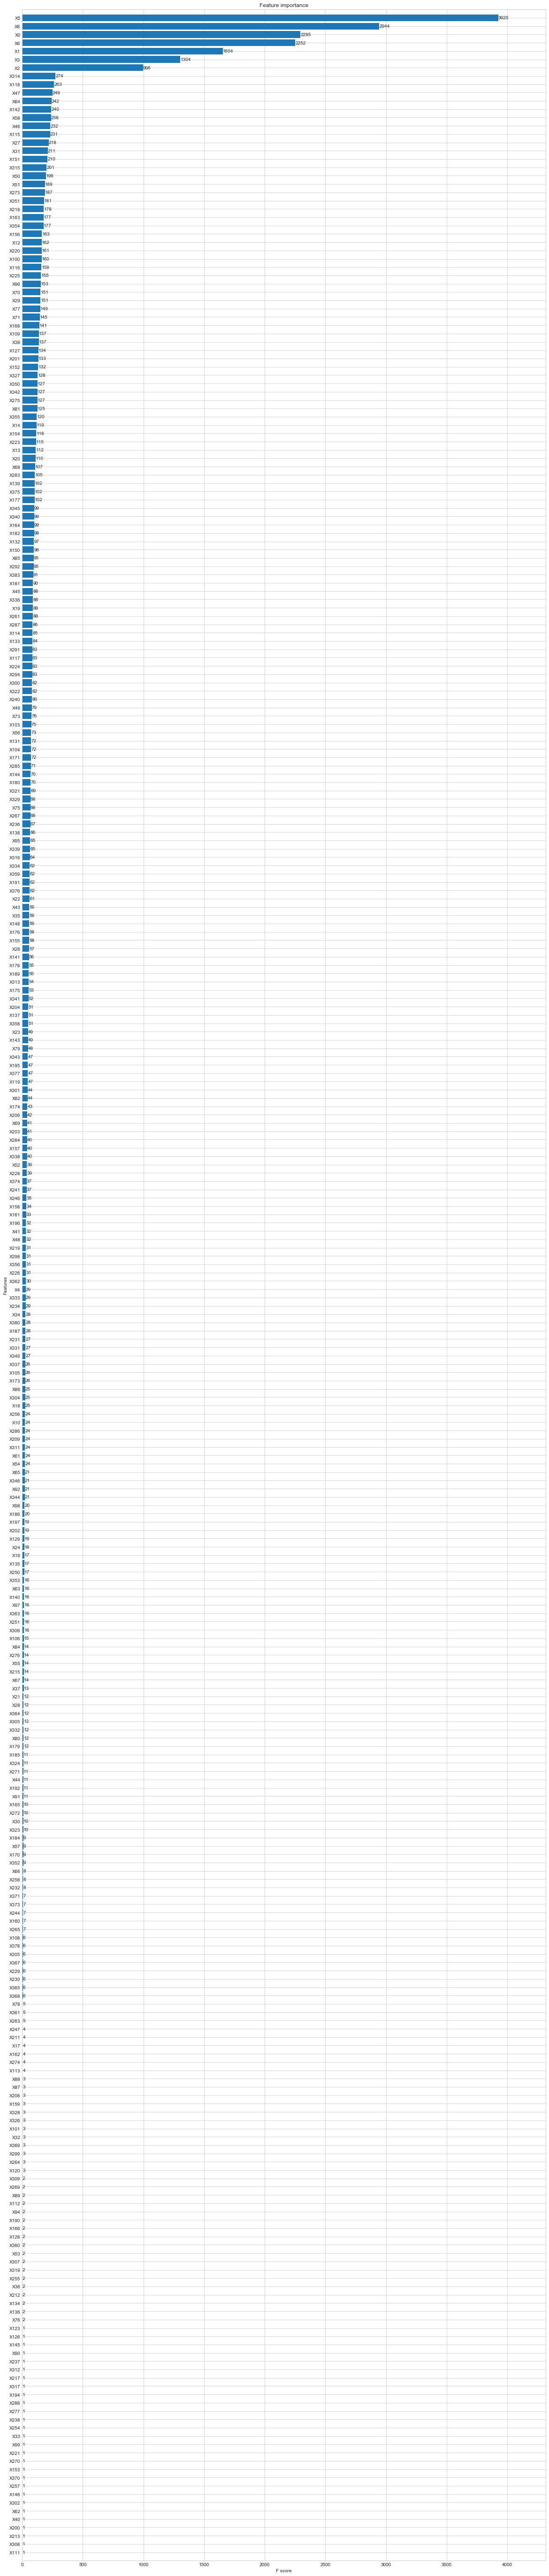

In [193]:
#variables les plus importante
fig, ax = plt.subplots(figsize=(20,100))
xgb.plot_importance(model_1, height=0.8, ax=ax)

In [75]:
#utilisation du GradientBoostingRegressor
stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber", max_depth=3, max_features=0.55, min_samples_leaf=18, min_samples_split=14, subsample=0.7)),
    LassoLarsCV()
)
stacked_pipeline.fit(X_train, Y_train)
results = stacked_pipeline.predict(X_test)

C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.025e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.597e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.597e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_it

C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.933e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.495e-02, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.395e-02, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce ma

C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=7.366e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=3.809e-03, with an active set of 29 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=3.683e-03, with an active set of 33 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce m

ValueError: could not convert string to float: 'r'

In [ ]:
from sklearn import *

In [176]:
Y_predict

array([  79.56459808,   96.78109741,   80.06500244, ...,   91.22626495,
        107.25185394,   89.81809235], dtype=float32)

In [177]:
Y_predict.mean()

99.021088

In [178]:
#prediction du temps de test pour chaque ID 
id_test = data_test['ID'].values
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = Y_predict
sub.to_csv('xgbpred_model.csv', index=False)

In [175]:
id_test = data_test['ID'].values
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = Y_predict*0.6 + results*0.4
sub.to_csv('xgbpred&stacked_pipeline.csv', index=False)


In [179]:
#GradientBoostingRegressor
id_test = data_test['ID'].values
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = results
sub.to_csv('GradientBoostingRegressor.csv', index=False)


In [180]:

#R2 Score 

print('score R2 pour le model_3')
print(r2_score(Y_train,stacked_pipeline.predict(X_train)))

score R2 pour le model_3
0.577591014247


In [181]:
#R2 Score 

print('score R2 pour le model 1')
print(r2_score(Y_train,model_1.predict(X_train)))

score R2 pour le model 1
0.703150379196


In [ ]:
#random Forest

In [196]:
from sklearn import ensemble
model_2 = ensemble.RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model_2.fit(X_train,Y_train)
names = X_train.columns.values



In [201]:
#R2 Score 

print('score R2 pour le model 2')
print(r2_score(Y_train,model_2.predict(X_train)))

score R2 pour le model 2
0.633970004521


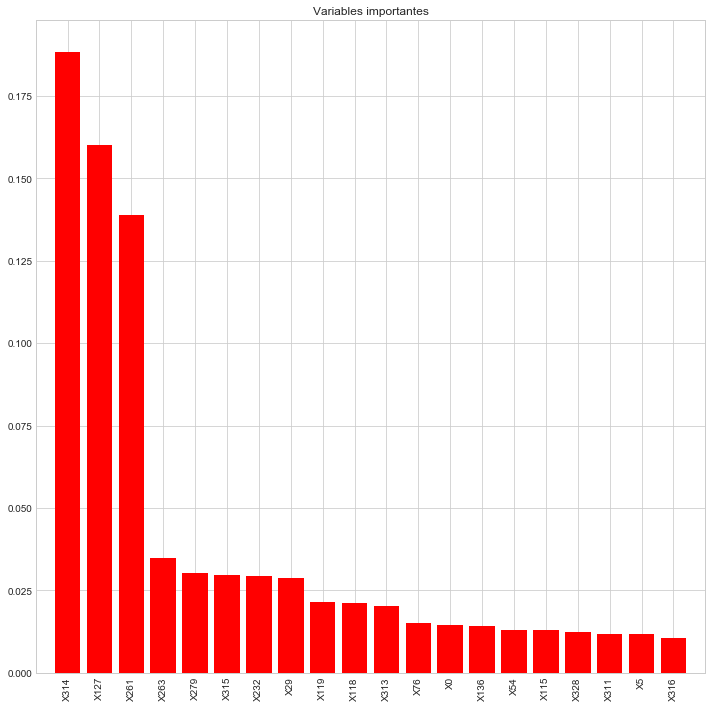

In [199]:
## plot the importances ##
importances = model_2.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_2.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Variables importantes")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()